In [1]:
import torch
import numpy as np
from PIL import Image

class Dataset(torch.utils.data.Dataset):
    def __init__(self, part):
        self.part = part
        self.data = np.loadtxt(fname='data/pika/%s.csv' % part,
                               delimiter=',')

    def __getitem__(self, idx):
        x = Image.open('data/pika/%s/%s.jpg' %
                       (self.part, idx)).convert('RGB')
        x = np.array(x)
        #[256, 256, 3] -> [3, 256, 256]
        x = x.transpose((0, 2, 1))
        x = x.transpose((1, 0, 2))

        x = torch.tensor(x)
        x = x.float()

        y = torch.FloatTensor(self.data[idx])

        return x, y

    def __len__(self):
        return len(self.data)


loader_train = torch.utils.data.DataLoader(dataset=Dataset(part='train'),
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=True)

loader_test = torch.utils.data.DataLoader(dataset=Dataset(part='test'),
                                          batch_size=32,
                                          shuffle=True,
                                          drop_last=True)

for i, (x, y) in enumerate(loader_train):
    break

x.shape, y.shape, x.dtype, y.dtype

(torch.Size([32, 3, 256, 256]),
 torch.Size([32, 4]),
 torch.float32,
 torch.float32)

In [2]:
#生成image_size**2个框,均匀分布在图片上
def get_anchor():
    image_size = 32
    anchor_size = 0.15
    #0-1等差数列,但不包括0和1,数量是image_size个
    """
    [0.015625 0.046875 0.078125 0.109375 0.140625 0.171875 0.203125 0.234375
     0.265625 0.296875 0.328125 0.359375 0.390625 0.421875 0.453125 0.484375
     0.515625 0.546875 0.578125 0.609375 0.640625 0.671875 0.703125 0.734375
     0.765625 0.796875 0.828125 0.859375 0.890625 0.921875 0.953125 0.984375]"""
    step = (np.arange(image_size) + 0.5) / image_size

    #生成中心点,数量是image_size**2
    point = []
    for i in range(image_size):
        for j in range(image_size):
            point.append([step[j], step[i]])

    #根据中心点,生成所有的坐标
    anchors = torch.empty(len(point), 4)
    for i in range(len(point)):
        #计算正方形的4个坐标点,分别是中心点和宽高的一半做加减
        anchors[i, 0] = point[i][0] - anchor_size / 2
        anchors[i, 1] = point[i][1] - anchor_size / 2
        anchors[i, 2] = point[i][0] + anchor_size / 2
        anchors[i, 3] = point[i][1] + anchor_size / 2

    return anchors


anchor = get_anchor()
anchor, anchor.shape

(tensor([[-0.0594, -0.0594,  0.0906,  0.0906],
         [-0.0281, -0.0594,  0.1219,  0.0906],
         [ 0.0031, -0.0594,  0.1531,  0.0906],
         ...,
         [ 0.8469,  0.9094,  0.9969,  1.0594],
         [ 0.8781,  0.9094,  1.0281,  1.0594],
         [ 0.9094,  0.9094,  1.0594,  1.0594]]),
 torch.Size([1024, 4]))

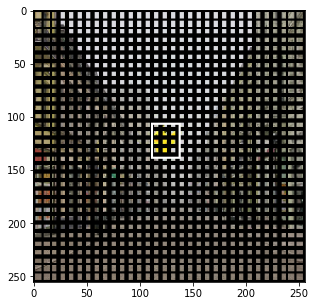

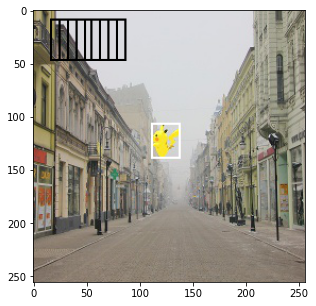

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import PIL.Image
import PIL.ImageDraw


#画出anchor
def show(x, y, anchor):
    x = x.detach().numpy()
    x = x.astype(np.uint8)

    #(3, 256, 256) -> (256, 256, 3)
    x = x.transpose((1, 0, 2))
    x = x.transpose((0, 2, 1))

    y = y.detach().numpy()
    y = y * 256.0

    image = PIL.Image.fromarray(x)
    draw = PIL.ImageDraw.Draw(image)

    #因为anchor的值域是0-1,需要转换到实际的图片尺寸.
    anchor = anchor.detach().numpy() * 256

    #画框
    for i in range(len(anchor)):
        draw.rectangle(xy=anchor[i], outline='black', width=2)

    draw.rectangle(xy=y, outline='white', width=2)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()


show(x[0], y[0], anchor)
show(x[0], y[0], anchor[100:105])

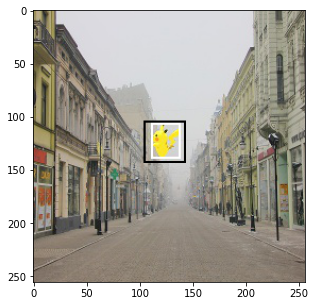

(tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 torch.Size([1024]),
 tensor(0.6138),
 tensor(495))

In [4]:
#求n个anchor和y的交并比
def get_iou(y):
    #anchor -> [1024, 4]
    #y -> [4]

    #x1-x0=宽
    #y1-y0=高
    #宽*高=面积
    anchor_w = anchor[:, 2] - anchor[:, 0]
    anchor_h = anchor[:, 3] - anchor[:, 1]
    #[1024]
    anchor_s = anchor_w * anchor_h

    #y部分的计算同理,形状都是[1],也就是标量
    y_w = y[2] - y[0]
    y_h = y[3] - y[1]
    y_s = y_w * y_h

    #求重叠部分坐标
    cross = torch.empty(anchor.shape)

    #左上角坐标取最大值,也就是取最右,下的点
    cross[:, 0] = torch.max(anchor[:, 0], y[0])
    cross[:, 1] = torch.max(anchor[:, 1], y[1])

    #右下角坐标取最小值,也就是取最左,上的点
    cross[:, 2] = torch.min(anchor[:, 2], y[2])
    cross[:, 3] = torch.min(anchor[:, 3], y[3])

    #右下坐标-左上坐标=重叠部分的宽度,高度
    #如果两个矩形完全没有重叠,这里会出现负数
    #这里不允许出现负数,所以最小值是0
    cross_w = (cross[:, 2] - cross[:, 0]).clamp(min=0)
    cross_h = (cross[:, 3] - cross[:, 1]).clamp(min=0)

    #宽和高相乘,等于重叠部分面积,当然,宽和高中任意一个为0,则面积为0
    #[1024]
    cross_s = cross_w * cross_h

    #求并集面积
    #[1024]
    union_s = anchor_s + y_s - cross_s

    #交并比,等于交集面积/并集面积
    #[4]
    return (cross_s / union_s)


iou = get_iou(y[0])

show(x[0], y[0], anchor[iou.argmax()].unsqueeze(dim=0))

iou, iou.shape, iou.max(), iou.argmax()

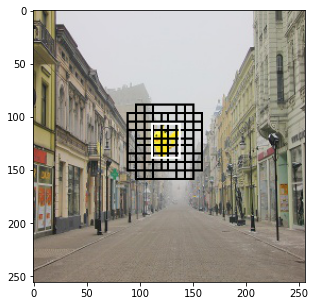

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([32, 1024]),
 tensor([11.1583, 14.4880,  8.6413, 10.8760, 16.1102, 12.7455, 10.8502,  8.4782,
          8.7733, 12.0521, 16.8844, 13.3988, 14.3227,  8.8294,  9.5060, 15.9664,
         11.7514, 12.9447, 11.2437, 13.1888, 10.8836, 13.9681,  9.7739, 11.1758,
         10.5139, 16.2194, 12.7373, 11.8722, 15.0892, 11.9272, 16.0775, 14.5930]))

In [5]:
def get_target(y):
    #anchor -> [1024, 4]
    #y -> [32, 4]

    #计算每个定位框和每个y的交并比
    target = torch.zeros(32, 1024)
    for i in range(32):
        target[i] = get_iou(y[i])

    return target


target = get_target(y)

show(x[0], y[0], anchor[target[0] > 0.2])

target, target.shape, target.sum(dim=1)

In [6]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        def get_block(in_channels, out_channels):
            block = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=3,
                                padding=1),
                torch.nn.BatchNorm2d(num_features=out_channels),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=out_channels,
                                out_channels=out_channels,
                                kernel_size=3,
                                padding=1),
                torch.nn.BatchNorm2d(num_features=out_channels),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
            )
            return block

        self.cnn = torch.nn.Sequential(
            #[32, 3, 256, 256] -> [32, 16, 128, 128]
            get_block(in_channels=3, out_channels=16),

            #[32, 16, 128, 128] -> [32, 32, 64, 64]
            get_block(in_channels=16, out_channels=32),

            #[32, 32, 64, 64] -> [32, 64, 32, 32]
            get_block(in_channels=32, out_channels=64),

            #[32, 64, 32, 32] -> [32, 128, 16, 16]
            get_block(in_channels=64, out_channels=128),

            #[32, 128, 16, 16] -> [32, 256, 8, 8]
            get_block(in_channels=128, out_channels=256),

            #[32, 256, 8, 8] -> [32, 512, 4, 4]
            get_block(in_channels=256, out_channels=512),

            #[32, 512, 4, 4] -> [32, 1024, 2, 2]
            get_block(in_channels=512, out_channels=1024),
        )

        #[32, 1024, 2, 2] -> [32, 2048, 1, 1]
        self.get_pred = torch.nn.Conv2d(in_channels=1024,
                                      out_channels=1024,
                                      kernel_size=2,
                                      padding=0)

    def forward(self, x):
        #[32, 3, 256, 256] -> [32, 1024, 2, 2]
        x = self.cnn(x)

        #[32, 1024, 2, 2] -> [32, 1024, 1, 1]
        pred = self.get_pred(x)

        #[32, 1024, 1, 1] -> [32, 1024]
        pred = pred.squeeze()

        return pred


model = Model()
pred = model(x)
pred.shape

torch.Size([32, 1024])

In [7]:
def train():
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    get_loss = torch.nn.MSELoss()

    #训练
    for epoch in range(10):
        model.train()
        for i, (x, y) in enumerate(loader_train):
            #x -> [32, 3, 256, 256]
            #y -> [32, 4]

            #预测
            #[32, 3, 256, 256] -> [32, 1024]
            pred = model(x)

            #获取网络计算目标
            #[32, 4] -> [32, 1024]
            target = get_target(y)

            #计算loss
            loss = get_loss(pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                print(epoch, i, loss.item())
                torch.save(model, './models/超简单版实现.model')


#train()

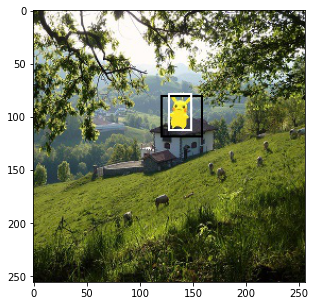

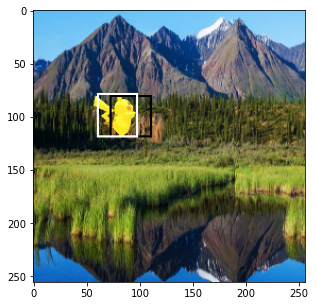

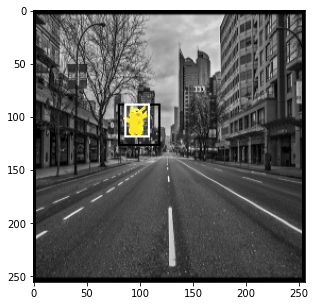

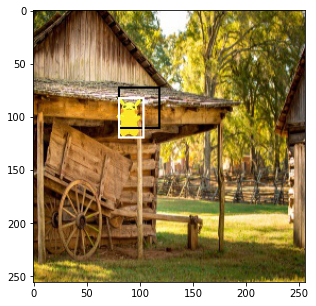

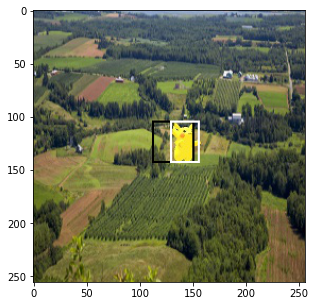

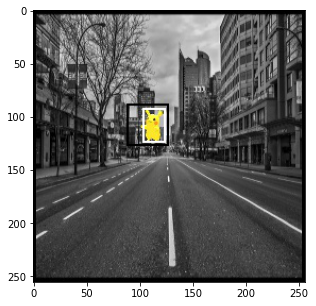

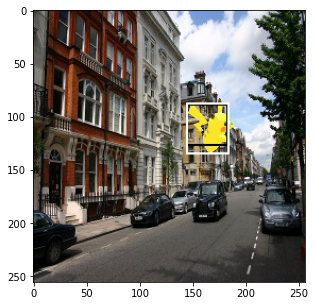

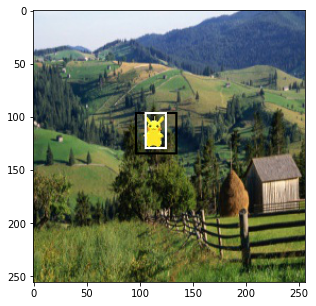

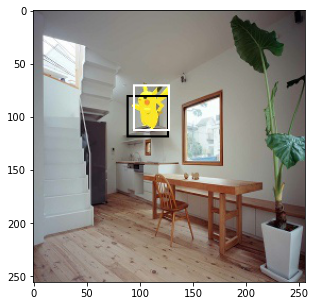

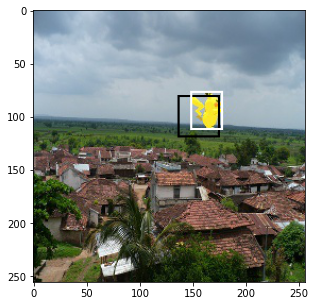

In [8]:
def predict(x):
    #x -> [32, 3, 256, 256]
    model.eval()

    #[32, 3, 256, 256] -> [32, 1024]
    pred = model(x)
    
    #[32, 1024] -> [32]
    pred = pred.argmax(dim=1)
    
    return pred


for i, (x, y) in enumerate(loader_test):
    break

model = torch.load('./models/超简单版实现.model')
pred = predict(x)

for i in range(10):
    show(x[i], y[i], anchor[pred[i]].unsqueeze(dim=0))